<a href="https://colab.research.google.com/github/ramesh-078/Data-Science-Task/blob/main/Worldwide_Food_Waste_Analysis_and_Country_Wise_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("aritra100/worldwide-food-waste-dataset")

print("Path to dataset files:", path)

100%|██████████| 107k/107k [00:00<00:00, 13.5MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/aritra100/worldwide-food-waste-dataset/versions/1


In [ ]:
import pandas as pd
import os

# List the contents of the downloaded directory to find the correct file name
print("Files in the downloaded directory:")
for root, dirs, files in os.walk(path):
    for name in files:
        print(os.path.join(root, name))
    for name in dirs:
        print(os.path.join(root, name))

df=pd.read_csv(os.path.join(path, "WorldWide_foodwastage_dataset.csv"))
print("sample rows")
print(df.head())
print("dataset shape")
print(f'Rows:{df.shape[0]},Columns:{df.shape[1]}')
print("Dataset info")
print(df.info())
print("Summary statistics")
print(df.describe(include='all'))
print("Missing values")
print(df.isnull().sum())

Files in the downloaded directory:
/root/.cache/kagglehub/datasets/aritra100/worldwide-food-waste-dataset/versions/1/WorldWide_foodwastage_dataset.csv
sample rows
     Country  Year           Food Types  Total Waste in Tons  \
0  Australia  2019  Fruits & Vegetables             19268.63   
1  Indonesia  2019        Prepared Food              3916.97   
2    Germany  2022       Dairy Products              9700.16   
3     France  2023  Fruits & Vegetables             46299.69   
4     France  2023            Beverages             33096.57   

   Food Economic Loss (Million $)  Avg Waste per Capita (Kg)  \
0                        18686.68                      72.69   
1                         4394.48                     192.52   
2                         8909.16                     166.94   
3                        40551.22                     120.19   
4                        36980.82                     104.74   

   Country Population (Million) (Not Accurate)  Household Waste (%)

In [ ]:
df.rename(columns={"Country Population (Million) (Not Accurate)": "Country Population"}, inplace=True)


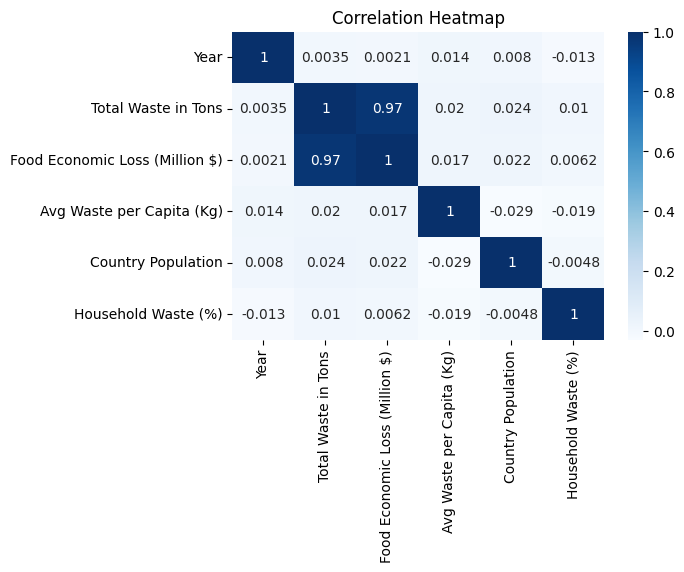

In [ ]:
#selecting only the non numeric columns
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
# Selecting only numeric columns for correlation calculation
sns.heatmap(df.select_dtypes(include=['number']).corr(), annot=True, cmap="Blues")
plt.title("Correlation Heatmap")
plt.show()

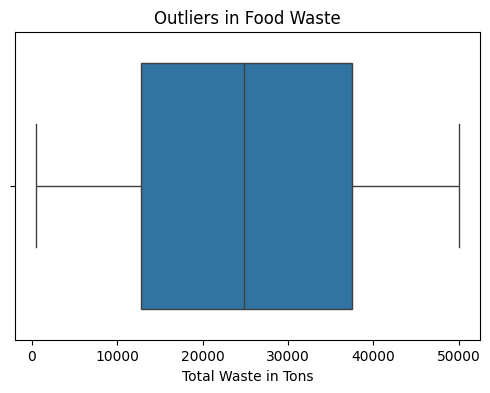

In [ ]:
#outliers in the food waste
plt.figure(figsize=(6,4))
sns.boxplot(x=df["Total Waste in Tons"])
plt.title("Outliers in Food Waste")
plt.show()


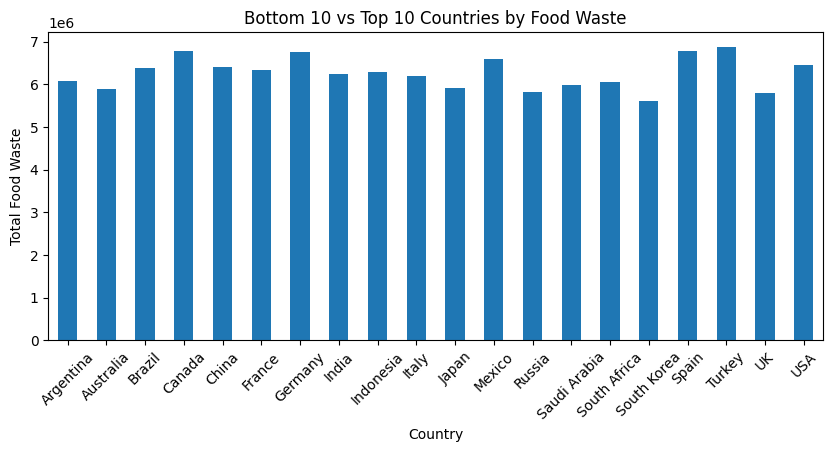

In [ ]:
#bottom and top country and their amount for food waste
country_waste=df.groupby("Country")["Total Waste in Tons"].sum()
bottom10 = country_waste.head(10)
top10 = country_waste.tail(10)

combined = pd.concat([bottom10, top10])

plt.figure(figsize=(10,4))
combined.plot(kind="bar")
plt.title("Bottom 10 vs Top 10 Countries by Food Waste")
plt.ylabel("Total Food Waste")
plt.xticks(rotation=45)
plt.show()


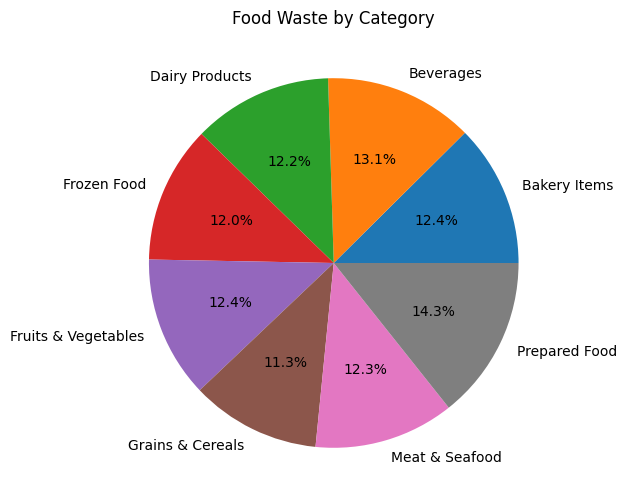

In [ ]:
category_waste = df.groupby("Food Types")["Total Waste in Tons"].sum()
plt.figure(figsize=(6,6))
category_waste.plot(kind="pie", autopct='%1.1f%%')
plt.title("Food Waste by Category")
plt.ylabel("")
plt.show()


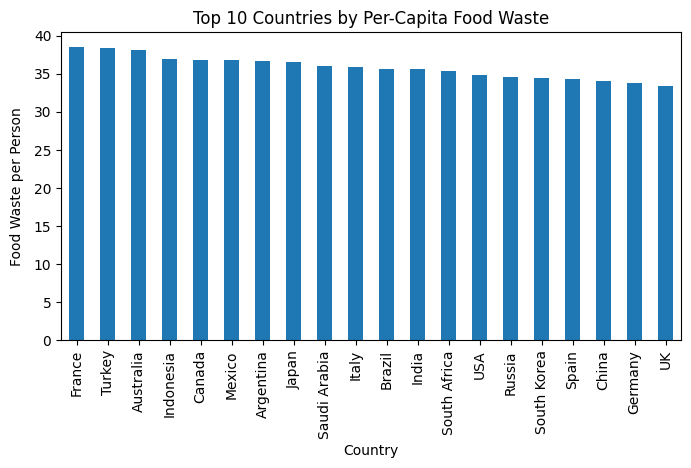

In [ ]:
#calculation the per capita of the food
country_year_waste = df.groupby(["Country", "Year"])[["Total Waste in Tons", "Country Population"]].sum().reset_index()

country_year_waste["per_capita_waste"] = (
    country_year_waste["Total Waste in Tons"] / country_year_waste["Country Population"]
)
per_capita_country = (
    country_year_waste
    .groupby("Country")["per_capita_waste"]
    .mean()
    .sort_values(ascending=False)
)
plt.figure(figsize=(8,4))
per_capita_country.head(20).plot(kind="bar",)
plt.title("Top 10 Countries by Per-Capita Food Waste")
plt.ylabel("Food Waste per Person",labelpad=7)
plt.show()


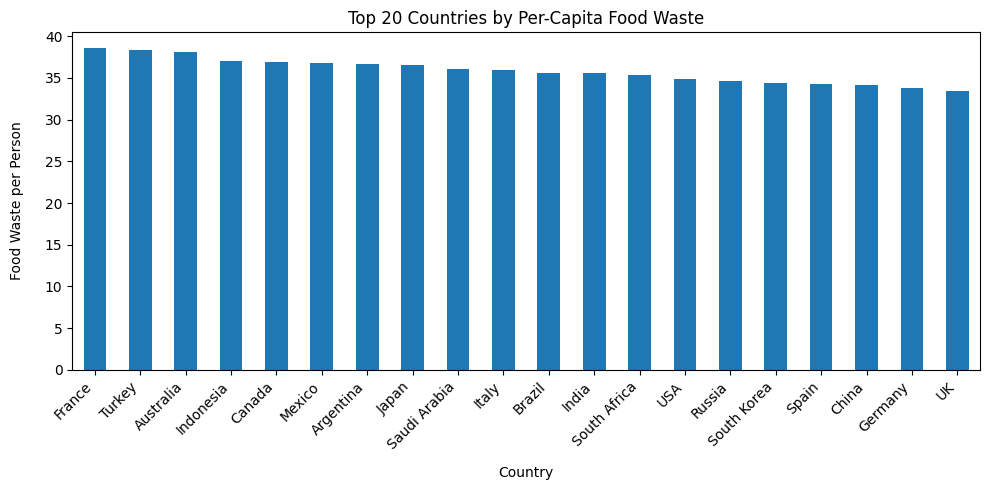

In [ ]:
plt.figure(figsize=(10,5))
per_capita_country.head(20).plot(kind="bar")
plt.ylabel("Food Waste per Person", labelpad=15)
plt.xlabel("Country", labelpad=10)
plt.title("Top 20 Countries by Per-Capita Food Waste")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()  # <-- this fixes cramped labels
plt.show()


In [ ]:
comparison = pd.DataFrame({
    "total_waste": df.groupby("Country")["Total Waste in Tons"].sum()
}).join(per_capita_country)


comparison.sort_values("total_waste", ascending=False).head(20)


,total_waste,per_capita_waste
Country,,
Turkey,6879885.81,38.346282
Canada,6790678.49,36.853021
Spain,6790574.25,34.255566
Germany,6760053.01,33.845221
Mexico,6589169.52,36.818228
USA,6446334.63,34.847472
China,6411096.18,34.100469
Brazil,6391752.50,35.627093
France,6334495.00,38.535886


In [ ]:
#ML model
df_ml = df.copy()
#remove the leakage column and use other
X = df_ml.drop("Total Waste in Tons", axis=1)
y = df_ml["Total Waste in Tons"]
X = pd.get_dummies(
    X,
    columns=["Country", "Food Types"],
    drop_first=True
)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("Linear Regression Performance")
print("MAE:", mean_absolute_error(y_test, y_pred_lr))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("R² Score:", r2_score(y_test, y_pred_lr))


Linear Regression Performance
MAE: 2547.1144031432273
RMSE: 3277.532835349936
R² Score: 0.9503528782100955


In [ ]:
#lets check whether the random forest works better
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest Performance")
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("R² Score:", r2_score(y_test, y_pred_rf))


Random Forest Performance
MAE: 2311.1384236000004
RMSE: 3068.8987028338247
R² Score: 0.9564723640387514


In [ ]:
#This clarifies the influence of the column in the food waste which has how much contribution to the food loss
feature_importance = pd.Series(
    rf.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

feature_importance.head(10)


,0
Food Economic Loss (Million $),0.966333
Country Population,0.006862
Avg Waste per Capita (Kg),0.006829
Household Waste (%),0.006738
Year,0.002682
Food Types_Beverages,0.000563
Food Types_Meat & Seafood,0.000549
Food Types_Dairy Products,0.000549
Food Types_Fruits & Vegetables,0.000508
Food Types_Prepared Food,0.000502


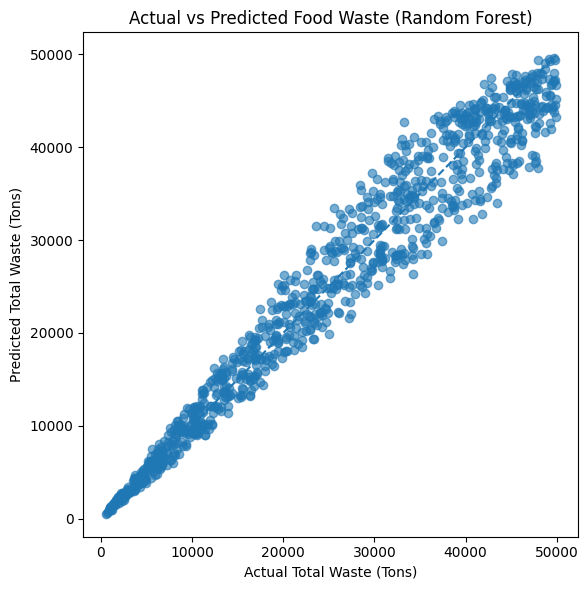

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_rf, alpha=0.6)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    linestyle="--"
)
plt.xlabel("Actual Total Waste (Tons)")
plt.ylabel("Predicted Total Waste (Tons)")
plt.title("Actual vs Predicted Food Waste (Random Forest)")
plt.tight_layout()
plt.show()


In [ ]:
#Now lets classify the country in the basisof the developing and the underdeveloped and then see the total number of waste
developed_countries = [
    "USA", "Canada", "Germany", "France", "UK", "Japan", "Australia"
]




In [ ]:
#EDA
df["development_status"] = df["Country"].apply(
    lambda x: "Developed" if x in developed_countries else "Developing"
)
status_waste = (
    df.groupby("development_status")["Total Waste in Tons"]
    .sum()
)

status_waste


,Total Waste in Tons
development_status,
Developed,43935035.09
Developing,81373865.27


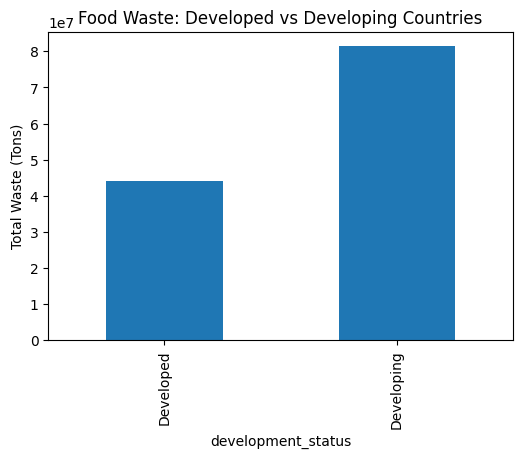

In [ ]:
status_waste.plot(kind="bar", figsize=(6,4))
plt.title("Food Waste: Developed vs Developing Countries")
plt.ylabel("Total Waste (Tons)")
plt.show()


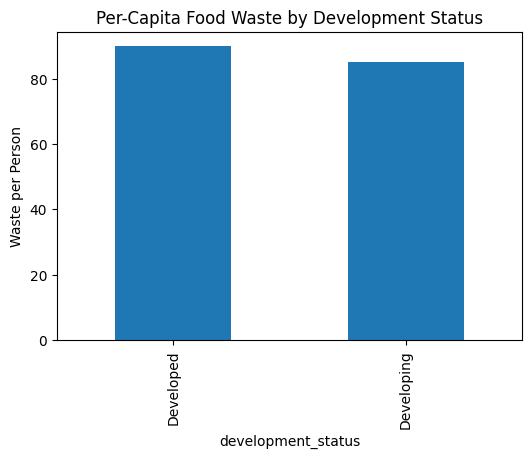

In [ ]:
#the total waste can be bias now lets go with the per capita income
df["per_capita_waste"] = df["Total Waste in Tons"] / df["Country Population"]

per_capita_status = (
    df.groupby("development_status")["per_capita_waste"]
    .mean()
)

per_capita_status.plot(kind="bar", figsize=(6,4))
plt.title("Per-Capita Food Waste by Development Status")
plt.ylabel("Waste per Person")
plt.show()
